# Evaluate inversion results
This jupyter notebook evaluates and plots the results of the magnetic-only and gravity-only inversion for the SWARM project. In particular, this notebook plots the inversion stats, inverted field maps, depth slices, crosssections, density-suscptibility relationship and cluster locations for the Supplementary material.

### jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 07/10/2024

# Magnetic-only inversion

#### load python packages

In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
from tqdm.notebook import tqdm, trange
import time  # to be used in loop iterations
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import glob
from PIL import Image
from scipy.interpolate import griddata

##### load data

In [2]:
inv_run = "SWARM_mag_only/"

export_fig_path = inv_run + "Output/Figure/"

# Create path if it does not exists
if not os.path.exists(export_fig_path):
    os.makedirs(export_fig_path)

In [3]:
unit_dens = "kg/m$^3$"
unit_sus = "SI"

cmap = cm.roma_r
cmap_rev = cm.roma_r
cmap_diff = cm.vik

In [4]:
x_study_area = [-1689000, -1656500, -1656500, -1689000, -1689000]
y_study_area = [1723500, 1723500, 1802000, 1802000, 1723500]

In [5]:
##### Mag data ######
nc1 = nc4.Dataset(inv_run + "VI_inversion/magdata.nc")  # mag data set
X_input_mag = nc1.variables["MeasPosX"][:]  # x coordinates
Y_input_mag = nc1.variables["MeasPosY"][:]  # y coordinates
val_input_mag = nc1.variables["T"][:]  # magnetic data
unit_mag = "nT"

#### Mag ####
G1 = nc4.Dataset(inv_run + "VI_inversion/result.inv_mag.nc")  # syn mag data set
X_syn_mag = G1.variables["MeasPosX"][:]  # x coordinates
Y_syn_mag = G1.variables["MeasPosY"][:]  # y coordinates
val_syn_mag = G1.variables["T"][:]  # syn magnetic data

diff_mag = val_input_mag - val_syn_mag  # difference observed and syn magnetic data
diff_mag_pd = pd.DataFrame(diff_mag, columns=["diff_mag"])
mxn_mag = max(abs(max(diff_mag)), abs(min(diff_mag)))

nc1.close()
G1.close()

# load missift and rms data
rms = np.genfromtxt(inv_run + "VI_inversion/rms.out")
misfit = np.genfromtxt(inv_run + "VI_inversion/misfit.out")

# read in magnetic inversion model
mag_fh = Dataset(inv_run + "VI_inversion/result.mag.inv.nc")
X_sus = mag_fh.variables["Northing"][:]
Y_sus = mag_fh.variables["Easting"][:]
Depth_sus = mag_fh.variables["Depth"][:]
X_sus_Origin = mag_fh.variables["Northing_Origin"][:]
Y_sus_Origin = mag_fh.variables["Easting_Origin"][:]
Depth_sus_Origin = mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:, :, :]
mag_fh.close()

Boundaries_SWARM = pd.read_csv(
    "DATA/Topo_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "bedrock"],
)

max grav error : 185.5 nT
min grav error : -72.5 nT
mean grav error : 0.9 nT
std grav error : 10.7 nT 



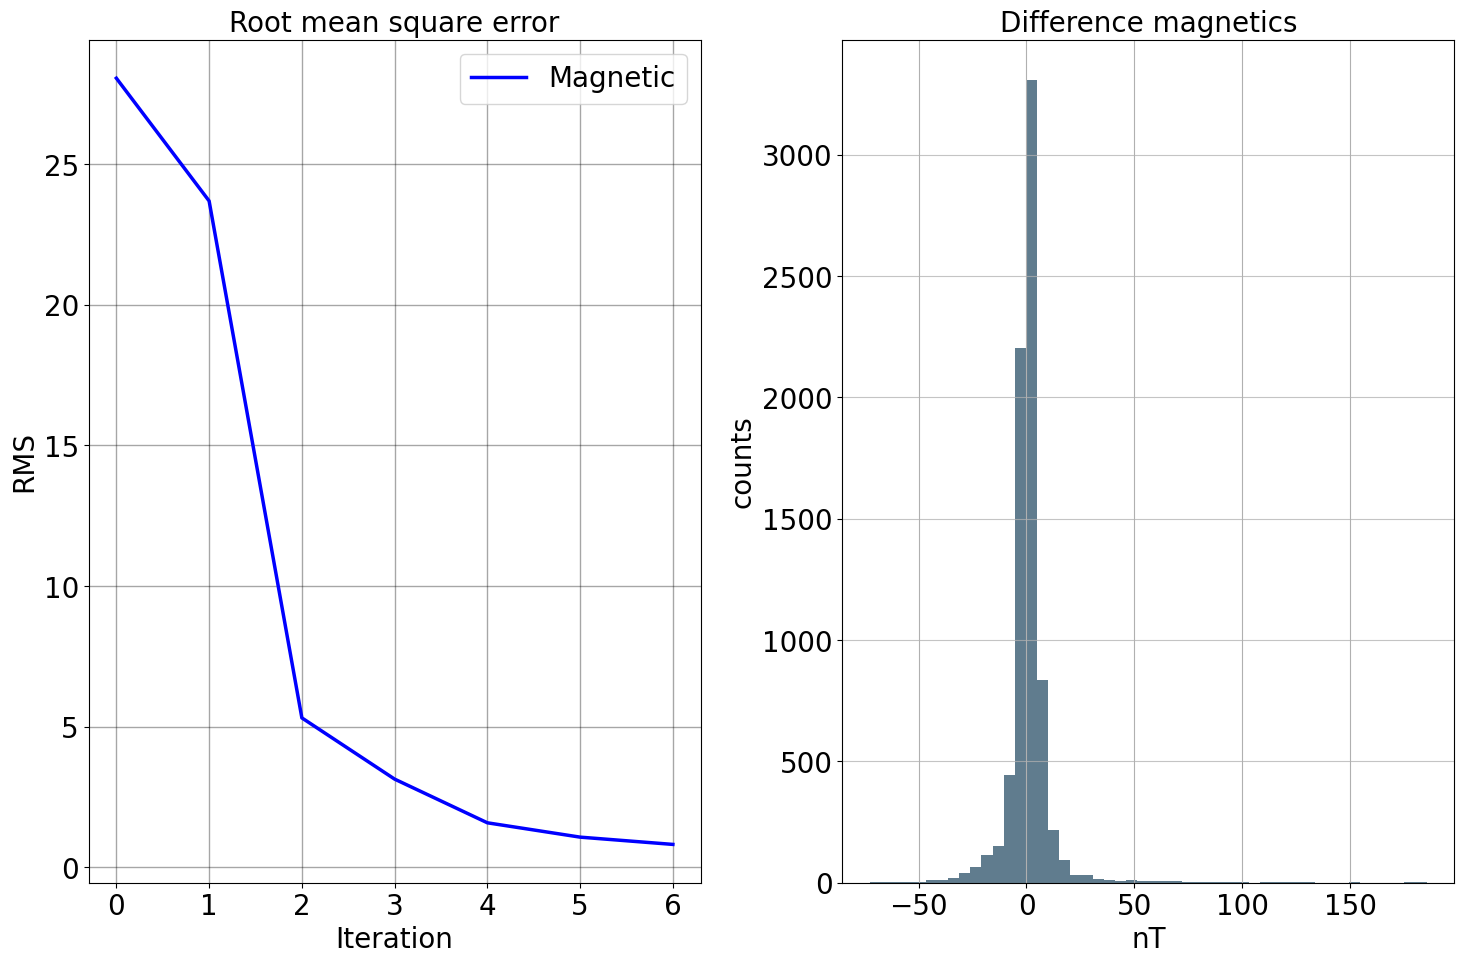

In [6]:
figure1, axs = plt.subplots(1, 2, figsize=(15, 10), facecolor="white")

axs[0].plot(rms[:, 1], "-b", linewidth=2.5, label="Magnetic")
axs[0].legend(loc="upper right", prop={"size": 20})
axs[0].set_title("Root mean square error", fontsize=20)
axs[0].set_xlabel("RMS", fontsize=20)
axs[0].grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
axs[0].set_xlabel("Iteration", fontsize=20)
axs[0].set_ylabel("RMS", fontsize=20)
axs[0].tick_params(axis="x", labelsize=20)
axs[0].tick_params(axis="y", labelsize=20)

diff_mag_pd.diff_mag.plot.hist(grid=True, bins=50, ax=axs[1], color="#607c8e")
axs[1].set_title("Difference magnetics", fontsize=20)
axs[1].set_xlabel("nT", fontsize=20)
axs[1].set_ylabel("counts", fontsize=20)
axs[1].grid(axis="y", alpha=0.75)
axs[1].tick_params(axis="x", labelsize=20)
axs[1].tick_params(axis="y", labelsize=20)

plt.savefig(
    inv_run + "Output/Figure/Mag_only_nversion_stats.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

figure1.tight_layout(pad=2)

print("max grav error :", "{0:.1f}".format(np.max(diff_mag)), "nT")
print("min grav error :", "{0:.1f}".format(np.min(diff_mag)), "nT"),
print("mean grav error :", "{0:.1f}".format(np.mean(diff_mag)), "nT")
print("std grav error :", "{0:.1f}".format(np.std(diff_mag)), "nT \n")

In [7]:
xq, yq = np.meshgrid(X_sus, Y_sus)
Depth_inversion_km = np.round((Depth_sus / 1000), 1)
Depth_sus

masked_array(data=[-2100., -1990., -1869., -1736., -1590., -1429., -1252.,
                   -1057.,  -843.,  -607.,  -348.,   -63.,   251.,   596.,
                     976.,  1394.,  1853.,  2358.,  2914.,  3526.,  4199.,
                    4939.,  5753.,  6648.,  7633.,  8716.,  9908., 11219.,
                   12661., 14247., 15992., 17911., 20022.],
             mask=False,
       fill_value=1e+20)

In [ ]:
m = 15  # fontsize

figure1 = plt.figure(figsize=(18, 10), facecolor="white")

# observed mag map
ax1 = plt.subplot(1, 3, 1)
im1 = plt.scatter(
    X_input_mag / 1000,
    Y_input_mag / 1000,
    c=val_input_mag,
    marker="s",
    s=15,
    cmap=cmap,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=1, pad=0.05)

cb1.ax.set_title(unit_mag, fontsize=m)
ax1.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)


# inverted mag map
ax2 = plt.subplot(1, 3, 2)

im2 = plt.scatter(
    X_syn_mag / 1000,
    Y_syn_mag / 1000,
    c=val_syn_mag,
    marker="s",
    s=15,
    cmap=cmap,
)

axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=1, pad=0.05)

cb2.ax.set_title(unit_mag, fontsize=m)

ax2.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)


# difference map
ax3 = plt.subplot(1, 3, 3)
im3 = plt.scatter(
    X_input_mag / 1000,
    Y_input_mag / 1000,
    c=diff_mag,
    marker="s",
    s=15,
    cmap=cmap_diff,
    vmin=-25,
    vmax=25,
)

axes = plt.gca()
cb3 = plt.colorbar(im3, orientation="vertical", shrink=1, pad=0.05)

cb3.ax.set_title(unit_mag, fontsize=m)
ax3.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)


plt.savefig(
    inv_run + "Output/Figure/mag_only_inversion_results_maps.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
export_sus_dens_slide = inv_run + "Output/Figure/Fig1_inverted_dens_depth_slices/"
if not os.path.exists(export_sus_dens_slide):
    os.makedirs(export_sus_dens_slide)

for c in tqdm(range(len(Depth_inversion_km))):

    figure1 = plt.figure(figsize=(5, 8), facecolor="white")
    inv_sus_depth_slice = inv_sus[c, :, :]
    ax1 = plt.subplot(1, 1, 1)

    plt.title("susceptibility at {:.1f} km depth".format(Depth_inversion_km[c]))
    im1 = plt.pcolormesh(
        xq,
        yq,
        inv_sus_depth_slice,
        cmap=cmap_rev,
        vmin=-0.06,
        vmax=0.06,
    )
    axes = plt.gca()
    cb = plt.colorbar(im1, shrink=1)
    cb.ax.set_title(unit_sus, fontsize=10)
    ax1.plot(x_study_area, y_study_area, "r", linewidth=2, label="study area")
    ax1.legend(loc="lower right", prop={"size": 10})
    ax1.set_aspect(1)
    export_name = export_sus_dens_slide + "horizontal_slice_{}.png".format(c + 100)
    plt.savefig(
        export_name, dpi=300, facecolor=figure1.get_facecolor(), transparent=True
    )
    plt.close()

In [ ]:
topointer = griddata(
    (Boundaries_SWARM.x_ps, Boundaries_SWARM.y_ps),
    Boundaries_SWARM.bedrock,
    (xq, yq),
    method="linear",
)

x_profil, z_profil = np.meshgrid(X_sus, Depth_sus)

In [ ]:
export_profiles = inv_run + "Output/Figure/profiles/"

# Create path if it does not exists
if not os.path.exists(export_profiles):
    os.makedirs(export_profiles)

# define fontsize
fontsize_index = 10

j = 209

sus_profil_ix = inv_sus[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_sus[:, j, :]

## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = plt.pcolormesh(
    x_profil / 1000, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(x_profil[0, :] / 1000, topointer[j, :] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "density_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
# Merge data variables into one data container to identify profile coordinates and data
Mag_obs_merged = np.vstack((X_input_mag, Y_input_mag, val_input_mag)).T
Mag_syn_merged = np.vstack((X_syn_mag, Y_syn_mag, val_syn_mag)).T

In [ ]:
# find data points for horizontal profile

obs_mag_horizontal_profile_ix = []
for i in range(len(Mag_obs_merged[:, 0])):
    if Mag_obs_merged[i, 1] == 1772500:
        obs_mag_horizontal_profile_ix.append(Mag_obs_merged[i, :])
obs_mag_horizontal_profile = np.array(obs_mag_horizontal_profile_ix)


syn_mag_horizontal_profile_ix = []
for i in range(len(Mag_syn_merged[:, 0])):
    if Mag_syn_merged[i, 1] == 1772500:
        syn_mag_horizontal_profile_ix.append(Mag_syn_merged[i, :])
syn_mag_horizontal_profile = np.array(syn_mag_horizontal_profile_ix)

In [ ]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_mag_horizontal_profile[:, 0] / 1000,
    obs_mag_horizontal_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed magnetic field",
)
plt.plot(
    syn_mag_horizontal_profile[:, 0] / 1000,
    syn_mag_horizontal_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Inverted magnetic field",
)
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax2.legend(loc="upper right", prop={"size": 10})
ax2.set_ylabel("Magnetic anomaly [nT]", fontsize=15)
ax2.set_xlabel("X polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "magnetic_data_points_along_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
y_profil, z_profil = np.meshgrid(Y_sus, Depth_sus)

j = 117

# define fontsize
fontsize_index = 10

sus_profil_ix = inv_sus[:, :, j]
line_x = (xq[0, j], xq[0, j])
line_y = (min(y_profil[0, :]), max(y_profil[0, :]))

sus_profil_ix = inv_sus[:, :, j]


## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    y_profil / 1000, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(y_profil[0, :] / 1000, topointer[:, j] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "susceptibility_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
# find data points for horizontal profile
obs_mag_vertical_profile_ix = []
for i in range(len(Mag_obs_merged[:, 0])):
    if Mag_obs_merged[i, 0] == -1663000:
        obs_mag_vertical_profile_ix.append(Mag_obs_merged[i, :])
obs_mag_vertical_profile = np.array(obs_mag_vertical_profile_ix)

syn_mag_vertical_profile_ix = []
for i in range(len(Mag_syn_merged[:, 1])):
    if Mag_syn_merged[i, 0] == -1663000:
        syn_mag_vertical_profile_ix.append(Mag_syn_merged[i, :])
syn_mag_vertical_profile = np.array(syn_mag_vertical_profile_ix)

In [ ]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_mag_vertical_profile[:, 1] / 1000,
    obs_mag_vertical_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed magnetic field",
)
plt.plot(
    syn_mag_vertical_profile[:, 1] / 1000,
    syn_mag_vertical_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Inverted magnetic field",
)
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
ax2.legend(loc="upper right", prop={"size": 10})
ax2.set_ylabel("Magnetic anomaly [nT]", fontsize=15)
ax2.set_xlabel("Y polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "magnetic_data_points_along_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

# Gravity-only inversion

In [ ]:
inv_run = "SWARM_grav_only/"

export_fig_path = inv_run + "Output/Figure/"

# Create path if it does not exists
if not os.path.exists(export_fig_path):
    os.makedirs(export_fig_path)

In [ ]:
##### Grav data ######
nc1 = nc4.Dataset(inv_run + "VI_inversion/gravdata.nc")  # mag data set
X_input_grav = nc1.variables["MeasPosX"][:]  # x coordinates
Y_input_grav = nc1.variables["MeasPosY"][:]  # y coordinates
val_input_grav = nc1.variables["Scalar_gravity"][:] * 1e5  # grav data
unit_grav = "mGal"

#### Mag ####
G1 = nc4.Dataset(inv_run + "VI_inversion/result.inv_sgd.nc")  # syn mag data set
X_syn_grav = G1.variables["MeasPosX"][:]  # x coordinates
Y_syn_grav = G1.variables["MeasPosY"][:]  # y coordinates
val_syn_grav = G1.variables["Scalar_gravity"][:] * 1e5  # syn grav data

diff_grav = val_input_grav - val_syn_grav  # difference observed and syn magnetic data
diff_grav_pd = pd.DataFrame(diff_grav, columns=["diff_grav"])
mxn_grav = max(abs(max(diff_grav)), abs(min(diff_grav)))

nc1.close()
G1.close()


# load missift and rms data
rms = np.genfromtxt(inv_run + "VI_inversion/rms.out")
misfit = np.genfromtxt(inv_run + "VI_inversion/misfit.out")


# read in magnetic inversion model
grav_fh = Dataset(inv_run + "VI_inversion/result.grav.inv.nc")
X_dens = grav_fh.variables["Northing"][:]
Y_dens = grav_fh.variables["Easting"][:]
Depth_dens = grav_fh.variables["Depth"][:]
X_dens_Origin = grav_fh.variables["Northing_Origin"][:]
Y_dens_Origin = grav_fh.variables["Easting_Origin"][:]
Depth_dens_Origin = grav_fh.variables["Depth_Origin"][:]
inv_dens = grav_fh.variables["Density"][:, :, :]
grav_fh.close()

Boundaries_SWARM = pd.read_csv(
    "DATA/Topo_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "bedrock"],
)

In [ ]:
figure1, axs = plt.subplots(1, 2, figsize=(15, 10), facecolor="white")

axs[0].plot(rms[:, 1], "-r", linewidth=2.5, label="gravity")
axs[0].legend(loc="upper right", prop={"size": 20})
axs[0].set_title("Root mean square error", fontsize=20)
axs[0].set_xlabel("RMS", fontsize=20)
axs[0].grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
axs[0].set_xlabel("Iteration", fontsize=20)
axs[0].set_ylabel("RMS", fontsize=20)
axs[0].tick_params(axis="x", labelsize=20)
axs[0].tick_params(axis="y", labelsize=20)


diff_grav_pd.diff_grav.plot.hist(grid=True, bins=50, ax=axs[1], color="#607c8e")
axs[1].set_title("Difference magnetics", fontsize=20)
axs[1].set_xlabel("nT", fontsize=20)
axs[1].set_ylabel("counts", fontsize=20)
axs[1].grid(axis="y", alpha=0.75)
axs[1].tick_params(axis="x", labelsize=20)
axs[1].tick_params(axis="y", labelsize=20)

plt.savefig(
    inv_run + "Output/Figure/Mag_only_nversion_stats.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)


figure1.tight_layout(pad=2)

print("max grav error :", "{0:.1f}".format(np.max(diff_grav)), "nT")
print("min grav error :", "{0:.1f}".format(np.min(diff_grav)), "nT"),
print("mean grav error :", "{0:.1f}".format(np.mean(diff_grav)), "nT")
print("std grav error :", "{0:.1f}".format(np.std(diff_grav)), "nT \n")

In [ ]:
xq, yq = np.meshgrid(X_dens, Y_dens)
Depth_inversion_km = np.round((Depth_dens / 1000), 1)
Depth_dens

In [ ]:
m = 15  # fontsize

figure1 = plt.figure(figsize=(18, 10), facecolor="white")

# observed mag map
ax1 = plt.subplot(1, 3, 1)
im1 = plt.scatter(
    X_input_grav / 1000,
    Y_input_grav / 1000,
    c=val_input_grav,
    marker="s",
    s=15,
    cmap=cmap,
)
axes = plt.gca()
cb1 = plt.colorbar(im1, orientation="vertical", shrink=1, pad=0.05)

cb1.ax.set_title(unit_grav, fontsize=m)
ax1.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)


# inverted mag map
ax2 = plt.subplot(1, 3, 2)

im2 = plt.scatter(
    X_syn_grav / 1000,
    Y_syn_grav / 1000,
    c=val_syn_grav,
    marker="s",
    s=15,
    cmap=cmap,
)

axes = plt.gca()
cb2 = plt.colorbar(im2, orientation="vertical", shrink=1, pad=0.05)

cb2.ax.set_title(unit_grav, fontsize=m)

ax2.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)


# difference map
ax3 = plt.subplot(1, 3, 3)
im3 = plt.scatter(
    X_input_grav / 1000,
    Y_input_grav / 1000,
    c=diff_grav,
    marker="s",
    s=15,
    cmap=cmap_diff,
    vmin=-25,
    vmax=25,
)

axes = plt.gca()
cb3 = plt.colorbar(im3, orientation="vertical", shrink=1, pad=0.05)

cb3.ax.set_title(unit_grav, fontsize=m)
ax3.plot(
    [-1690000 / 1000, -1690000 / 1000 + 10000 / 1000],
    [1720000 / 1000, 1720000 / 1000],
    "-k",
    linewidth=5,
)  # 10 km scale bar
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)


plt.savefig(
    inv_run + "Output/Figure/grav_only_inversion_results_maps.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
export_sus_dens_slide = inv_run + "Output/Figure/Fig1_inverted_dens_depth_slices/"
if not os.path.exists(export_sus_dens_slide):
    os.makedirs(export_sus_dens_slide)

for c in tqdm(range(len(Depth_inversion_km))):

    figure1 = plt.figure(figsize=(5, 8), facecolor="white")
    inv_dens_depth_slice = inv_dens[c, :, :]
    ax1 = plt.subplot(1, 1, 1)

    plt.title("Density at {:.1f} km depth".format(Depth_inversion_km[c]))
    im1 = plt.pcolormesh(
        xq,
        yq,
        inv_dens_depth_slice,
        cmap=cmap_rev,
        vmin=-250,
        vmax=250,
    )
    axes = plt.gca()
    cb = plt.colorbar(im1, shrink=1)
    cb.ax.set_title(unit_dens, fontsize=10)
    ax1.plot(x_study_area, y_study_area, "r", linewidth=2, label="study area")
    ax1.legend(loc="lower right", prop={"size": 10})
    ax1.set_aspect(1)
    export_name = export_sus_dens_slide + "horizontal_slice_{}.png".format(c + 100)
    plt.savefig(
        export_name, dpi=300, facecolor=figure1.get_facecolor(), transparent=True
    )
    plt.close()

In [ ]:
topointer = griddata(
    (Boundaries_SWARM.x_ps, Boundaries_SWARM.y_ps),
    Boundaries_SWARM.bedrock,
    (xq, yq),
    method="linear",
)

x_profil, z_profil = np.meshgrid(X_dens, Depth_dens)

In [ ]:
export_profiles = inv_run + "Output/Figure/profiles/"

# Create path if it does not exists
if not os.path.exists(export_profiles):
    os.makedirs(export_profiles)

# define fontsize
fontsize_index = 10

j = 209

sus_profil_ix = inv_dens[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_dens[:, j, :]

## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)


# plot sus profil
im2 = plt.pcolormesh(
    x_profil / 1000, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(x_profil[0, :] / 1000, topointer[j, :] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "density_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
# Merge data variables into one data container to identify profile coordinates and data
Grav_obs_merged = np.vstack((X_input_grav, Y_input_grav, val_input_grav)).T
Grav_syn_merged = np.vstack((X_syn_grav, Y_syn_grav, val_syn_grav)).T

In [ ]:
# find data points for horizontal profile

obs_grav_horizontal_profile_ix = []
for i in range(len(Grav_obs_merged[:, 0])):
    if Grav_obs_merged[i, 1] == 1772500:
        obs_grav_horizontal_profile_ix.append(Grav_obs_merged[i, :])
obs_grav_horizontal_profile = np.array(obs_grav_horizontal_profile_ix)


syn_grav_horizontal_profile_ix = []
for i in range(len(Grav_syn_merged[:, 0])):
    if Grav_syn_merged[i, 1] == 1772500:
        syn_grav_horizontal_profile_ix.append(Grav_syn_merged[i, :])
syn_grav_horizontal_profile = np.array(syn_grav_horizontal_profile_ix)

In [ ]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_grav_horizontal_profile[:, 0] / 1000,
    obs_grav_horizontal_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed gravity field",
)
plt.plot(
    syn_grav_horizontal_profile[:, 0] / 1000,
    syn_grav_horizontal_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Inverted gravity field",
)
ax2.set_xlim([-1685000 / 1000, -1656500 / 1000])
ax2.legend(loc="upper right", prop={"size": 10})
ax2.set_ylabel("Isostatic graviy anomaly [mGal]", fontsize=15)
ax2.set_xlabel("X polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "gravity_data_points_along_horizontal_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
y_profil, z_profil = np.meshgrid(Y_dens, Depth_dens)

j = 117


# define fontsize
fontsize_index = 10

sus_profil_ix = inv_dens[:, :, j]
line_x = (xq[0, j], xq[0, j])
line_y = (min(y_profil[0, :]), max(y_profil[0, :]))

dens_profil_ix = inv_dens[:, :, j]


## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    y_profil / 1000, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(y_profil[0, :] / 1000, topointer[:, j] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
plt.savefig(
    export_profiles + "density_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [ ]:
obs_grav_vertical_profile_ix = []
for i in range(len(Grav_obs_merged[:, 1])):
    if Grav_obs_merged[i, 0] == -1663000:
        obs_grav_vertical_profile_ix.append(Grav_obs_merged[i, :])
obs_grav_vertical_profile = np.array(obs_grav_vertical_profile_ix)

syn_grav_vertical_profile_ix = []
for i in range(len(Grav_syn_merged[:, 1])):
    if Grav_syn_merged[i, 0] == -1663000:
        syn_grav_vertical_profile_ix.append(Grav_syn_merged[i, :])
syn_grav_vertical_profile = np.array(syn_grav_vertical_profile_ix)

In [ ]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(
    obs_grav_vertical_profile[:, 1] / 1000,
    obs_grav_vertical_profile[:, 2],
    "o-k",
    linewidth=0.5,
    markersize=5,
    label="Observed gravity field",
)
plt.plot(
    syn_grav_vertical_profile[:, 1] / 1000,
    syn_grav_vertical_profile[:, 2],
    "o-r",
    linewidth=0.5,
    markersize=5,
    label="Inverted gravity field",
)
ax2.set_xlim([1733000 / 1000, 1799000 / 1000])
# ax2.set_ylim([25, 100])
ax2.legend(loc="upper right", prop={"size": 10})
ax2.set_ylabel("Isostatic graviy anomaly [mGal]", fontsize=15)
ax2.set_xlabel("Y polar stereographic coordinates [km]", fontsize=15)
ax2.grid(color="k", linestyle="-", linewidth=1, alpha=0.35, which="major")
plt.savefig(
    export_profiles + "gravity_data_points_along_vertical_profile.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)